In [119]:
import numpy as np

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import skfuzzy as fuzz
import skfuzzy.control as ctrl
from skfuzzy.control.controlsystem import CrispValueCalculator
from skfuzzy.control.term import WeightedTerm, TermAggregate

d:\conda\envs\comp_int\lib\site-packages\skfuzzy\control\fuzzyvariable.py:125: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


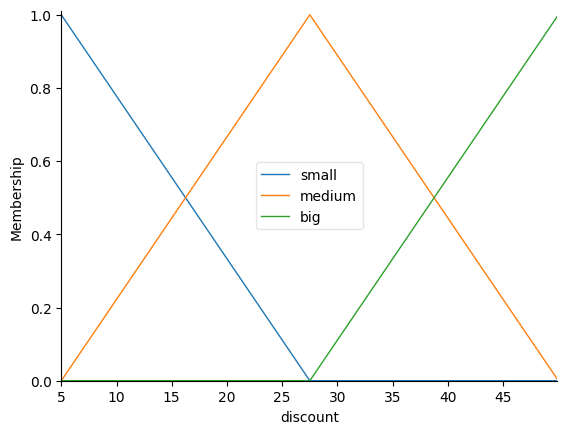

In [120]:
discount = ctrl.Antecedent(np.arange(5, 50, 0.1), 'discount')
discount['small'] = fuzz.trimf(discount.universe, [0.0, 5.0, 27.5])
discount['medium'] = fuzz.trimf(discount.universe, [5.0, 27.5, 50.0])
discount['big'] = fuzz.trimf(discount.universe, [27.5, 50.0, 55.0])

discount.view()

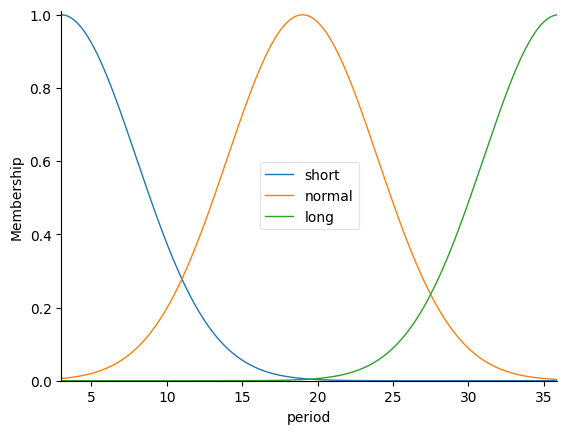

In [121]:
period = ctrl.Antecedent(np.arange(3, 36, 0.1), 'period')
period['short'] = fuzz.gaussmf(period.universe, 3, 5)
period['normal'] = fuzz.gaussmf(period.universe, 19, 5)
period['long'] = fuzz.gaussmf(period.universe, 36, 5)

period.view()

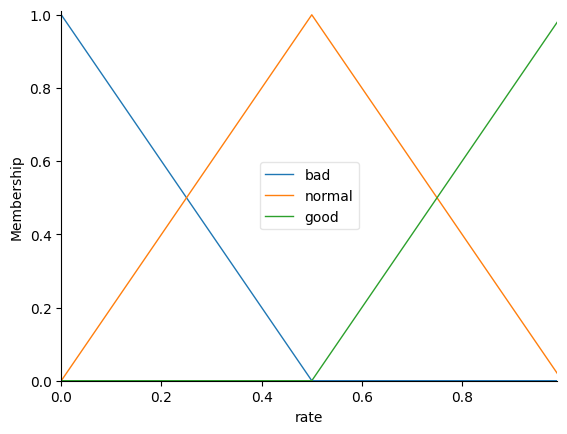

In [122]:
rate = ctrl.Consequent(np.arange(0.0, 1.0, 0.01), 'rate')
rate['bad'] = fuzz.trimf(rate.universe, [0.0, 0.0, 0.5])
rate['normal'] = fuzz.trimf(rate.universe, [0.0, 0.5, 1.0])
rate['good'] = fuzz.trimf(rate.universe, [0.5, 1.0, 1.0])

rate.view()

In [123]:
rule0 = ctrl.Rule(
    antecedent=(discount['small'] & period['short']),
    consequent=rate['good'], label='rule_0'
)

rule1 = ctrl.Rule(
    antecedent=(~discount['small'] & period['long']),
    consequent=rate['bad'], label='rule_1'
)

rule2 = ctrl.Rule(
    antecedent=(discount['medium'] & period['normal']),
    consequent=rate['normal'], label='rule_2'
)

rule3 = ctrl.Rule(
    antecedent=(discount['big'] & period['short']),
    consequent=rate['normal'], label='rule_3'
)

In [124]:
RESOLUTION = 20

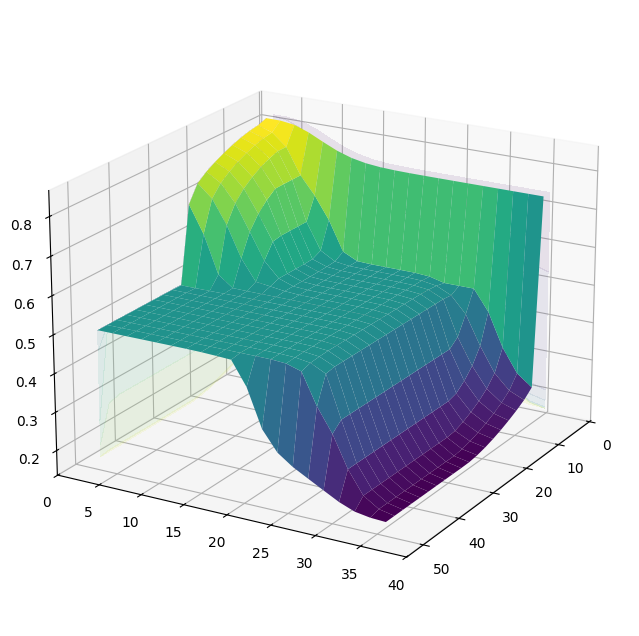

In [125]:
system = ctrl.ControlSystem(rules=[rule0, rule1, rule2, rule3])
sim = ctrl.ControlSystemSimulation(system, flush_after_run=RESOLUTION * RESOLUTION + 1)

# We can simulate at higher resolution with full accuracy
x_range = np.linspace(discount.universe[0], discount.universe[-1], RESOLUTION)
y_range = np.linspace(period.universe[0], period.universe[-1], RESOLUTION)
x, y = np.meshgrid(x_range, y_range)
z = np.zeros_like(x)

# Loop through the system 21*21 times to collect the control surface
for i in range(RESOLUTION):
    for j in range(RESOLUTION):
        sim.input['discount'] = x[i, j]
        sim.input['period'] = y[i, j]
        sim.compute()
        z[i, j] = sim.output['rate']

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(x, y, z, rstride=1, cstride=1, cmap='viridis',
                       linewidth=0.4, antialiased=True)

cset = ax.contourf(x, y, z, zdir='z', offset=-2.5, cmap='viridis', alpha=0.1)
cset = ax.contourf(x, y, z, zdir='x', offset=3, cmap='viridis', alpha=0.1)
cset = ax.contourf(x, y, z, zdir='y', offset=3, cmap='viridis', alpha=0.1)

ax.view_init(20, 30)

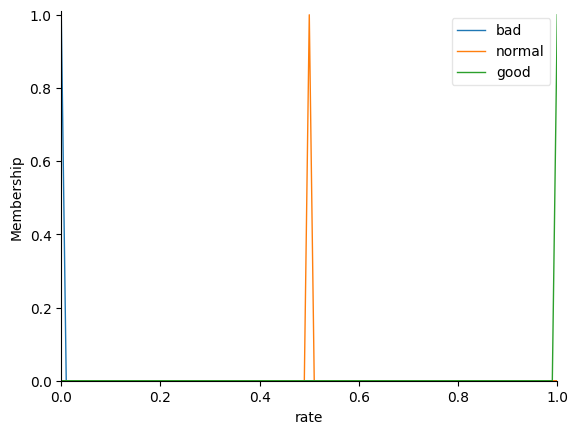

In [126]:
rate = ctrl.Consequent(np.arange(0.0, 1.01, 0.01), 'rate')
rate['bad'] = fuzz.trimf(rate.universe, [0.0, 0.0, 0.0])
rate['normal'] = fuzz.trimf(rate.universe, [0.5, 0.5, 0.5])
rate['good'] = fuzz.trimf(rate.universe, [1.0, 1.0, 1.0])

rate.view()

In [127]:
rule0 = ctrl.Rule(
    antecedent=(discount['small'] & period['short']),
    consequent=rate['good'], label='rule_0'
)

rule1 = ctrl.Rule(
    antecedent=(~discount['small'] & period['long']),
    consequent=rate['bad'], label='rule_1'
)

rule2 = ctrl.Rule(
    antecedent=(discount['medium'] & period['normal']),
    consequent=rate['normal'], label='rule_2'
)

rule3 = ctrl.Rule(
    antecedent=(discount['big'] & period['short']),
    consequent=rate['normal'], label='rule_3'
)

In [128]:
class SugenoControlSystemSimulation(ctrl.ControlSystemSimulation):
    def __init__(self, control_system, clip_to_bounds=True, cache=True, flush_after_run=1000):
        super().__init__(control_system, clip_to_bounds, cache, flush_after_run)
    
    def compute(self):
        """
        Compute the fuzzy system.
        """
        self.input._update_to_current()

        # Shortcut with lookup if this calculation was done before
        if self.cache is not False and self.unique_id in self._calculated:
            for consequent in self.ctrl.consequents:
                self.output[consequent.label] = consequent.output[self]
            return

        # If we get here, cache is disabled OR the inputs are novel. Compute!

        # Check if any fuzzy variables lack input values and fuzzify inputs
        for antecedent in self.ctrl.antecedents:
            if antecedent.input[self] is None:
                raise ValueError("All antecedents must have input values!")
            CrispValueCalculator(antecedent, self).fuzz(antecedent.input[self])

        # Calculate rules, taking inputs and accumulating outputs
        first = True
        for rule in self.ctrl.rules:
            # Clear results of prior runs from Terms if needed.
            if first:
                for c in rule.consequent:
                    c.term.membership_value[self] = None
                    c.activation[self] = None
                first = False
            self.compute_rule(rule)

        # Collect the results and present them as a dict
        for consequent in self.ctrl.consequents:
            wv, v = 0.0, 0.0
            for (t, var) in consequent.terms.items():
                t_wv = var.weighted_membership_value[self] * consequent.universe[np.argmax(var.mf)]
                wv += t_wv

                t_v = var.membership_value[self]
                v += t_v

            consequent.output[self] = wv / v
            self.output[consequent.label] = consequent.output[self]

        # Make note of this run so we can easily find it again
        if self.cache is not False:
            self._calculated.append(self.unique_id)
        else:
            # Reset StatePerSimulations
            self._reset_simulation()

        # Increment run number
        self._run += 1
        if self._run % self._flush_after_run == 0:
            self._reset_simulation()
    
    def compute_rule(self, rule):
        """
        Implement rule according to Sugeno inference.

        The three step method consists of::
         * Aggregation
         * Activation
         * Accumulation
        """
        # Step 1: Aggregation.  This finds the net accomplishment of the
        #  antecedent by AND-ing or OR-ing together all the membership values
        #  of the terms that make up the accomplishment condition.
        #  The process of actually aggregating everything is delegated to the
        #  TermAggregation class, but we can tell that class
        #  what aggregation style this rule mandates
        if isinstance(rule.antecedent, TermAggregate):
            rule.antecedent.agg_methods = rule._aggregation_methods
        rule.aggregate_firing[self] = rule.antecedent.membership_value[self]

        # Step 2: Activation.  The degree of membership of the consequence
        #  is determined by the degree of accomplishment of the antecedent,
        #  which is what we determined in step 1.  The only difference would
        #  be if the consequent has a weight, which we would apply now.
        for c in rule.consequent:
            assert isinstance(c, WeightedTerm)
            c.activation[self] = rule.aggregate_firing[self] * c.weight

        # Step 3: Accumulation.  Apply the activation to each consequent,
        #   accumulating multiple rule firings into a single membership value.
        #   The process of actual accumulation is delegated to the
        #   Term which uses its parent's accumulation method
        for c in rule.consequent:
            assert isinstance(c, WeightedTerm)
            term = c.term
            value = rule.aggregate_firing[self]

            # Find new membership value
            if term.membership_value[self] is None:
                term.membership_value[self] = value
                term.weighted_membership_value = {}
                term.weighted_membership_value[self] = c.activation[self]
            else:
                # Use the accumulation method of variable to determine
                #  how to to handle multiple cuts
                term.membership_value[self] = value + term.membership_value[self]
                term.weighted_membership_value[self] = c.activation[self] + term.weighted_membership_value[self]

            term.cuts[self][rule.label] = term.membership_value[self]

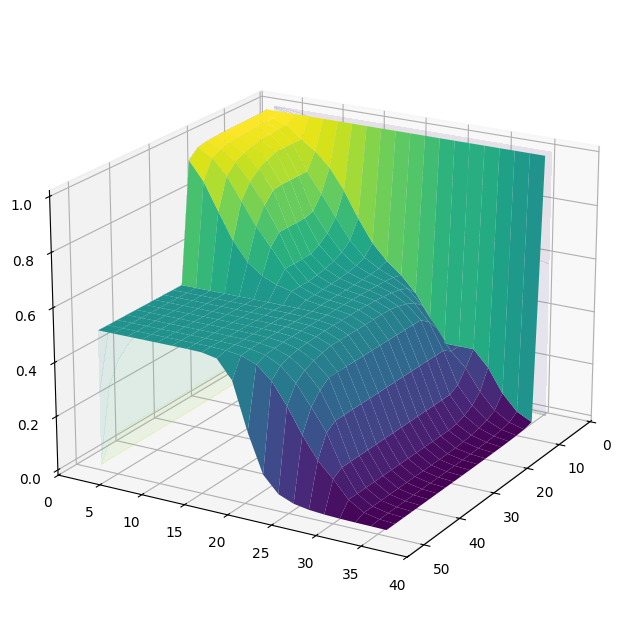

In [129]:
system = ctrl.ControlSystem(rules=[rule0, rule1, rule2, rule3])
sim = SugenoControlSystemSimulation(system, flush_after_run=RESOLUTION * RESOLUTION + 1)

# We can simulate at higher resolution with full accuracy
x_range = np.linspace(discount.universe[0], discount.universe[-1], RESOLUTION)
y_range = np.linspace(period.universe[0], period.universe[-1], RESOLUTION)
x, y = np.meshgrid(x_range, y_range)
z = np.zeros_like(x)

# Loop through the system 21*21 times to collect the control surface
for i in range(RESOLUTION):
    for j in range(RESOLUTION):
        sim.input['discount'] = x[i, j]
        sim.input['period'] = y[i, j]
        sim.compute()
        z[i, j] = sim.output['rate']

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(x, y, z, rstride=1, cstride=1, cmap='viridis',
                       linewidth=0.4, antialiased=True)

cset = ax.contourf(x, y, z, zdir='z', offset=-2.5, cmap='viridis', alpha=0.1)
cset = ax.contourf(x, y, z, zdir='x', offset=3, cmap='viridis', alpha=0.1)
cset = ax.contourf(x, y, z, zdir='y', offset=3, cmap='viridis', alpha=0.1)

ax.view_init(20, 30)